In [75]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation
import matplotlib.colors as colors
from matplotlib import cm
%matplotlib inline

In [76]:
def update_lines(num, data, plot, ax):
    '''
    Function which updates the lines for an animation. Does not 
    generate or append stuff, just takes progressively larger
    chunks of a pregenerated list of nodes for an arbitrary number 
    of lines.
    '''
    
    plot[0].remove()
    plot[0] = ax.plot_surface(xx, yy, data[num], rcount=20, ccount=20,
                            facecolors=cm.jet(data[0]), shade=False)
    plot[0].set_facecolor((0,0,0,0))
    return plot

def generate_plot_object(xx, yy, data):
    '''
    A function to generate the lines for a plot to be animated, initialised with the first
    nodes in the data array.
    '''
    #Source: https://matplotlib.org/examples/animation/simple_3danim.html
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    fig.set_size_inches(7, 7)
    

    # NOTE: Can't pass empty arrays into 3d version of plot()
    #surfaces = [ax.plot_surface(xx, yy, dat, rcount=20, ccount=20,
    #                       facecolors=cm.jet(dat), shade=False) for dat in data]
    
    surface = ax.plot_surface(xx, yy, data[0], rcount=20, ccount=20,
                            facecolors=cm.jet(data[0]), shade=False)
    surface.set_facecolor((0,0,0,0))
    
    # Setting the axes properties
    ax.set_xlim3d([-x_max, x_max])
    ax.set_xlabel('X')

    ax.set_ylim3d([-y_max, y_max])
    ax.set_ylabel('Y')

    ax.set_zlim3d([0.0, 3.0])
    ax.set_zlabel('Z')

    ax.set_title('Gaussian Wave')
    #fig.colorbar()
    
    return fig, ax, surface

def fixed_point(r, multiplyer=1, b=8/3):
    x = multiplyer*np.sqrt(b*(r-1))
    y = x
    z = r-1
    return x, y, z

In [151]:
def propogate_constant(xv, yv, dx, dy, dt, Nx, Ny, c=1.0, nsteps=1000, I=gaussian_2D, args=(0,0)):
    '''
    Propogates a wave through space using a vectorized finite differences method.
    
    WARNING: DON'T FORGET TO DEEP COPY.
    
    Params:
        xv - (1D array) X vector
        yv - (1D array) Y vector
        c - (float) Speed of light. Set to 1 usually cause physics.
    '''
    #Initial conditions
    f_a = np.zeros(xv.shape)
    u_last = np.zeros(xv.shape)
    us = []
    
    
    u   = np.zeros((Nx,Ny))   # solution array
    u_1 = np.zeros((Nx,Ny))   # solution at t-dt
    u_2 = np.zeros((Nx,Ny))   # solution at t-2*dt
    f_a = np.zeros((Nx,Ny))   # for compiled loops
    
    u[:,:] = I(xv, yv, *args)
    V_a = np.zeros(u.shape)
    
    stability_limit = (1/float(c))*(1/np.sqrt(1/dx**2 + 1/dy**2))
    if dt <= 0:                # max time step?
        safety_factor = -dt    # use negative dt as safety factor
        dt = safety_factor*stability_limit
    elif dt > stability_limit:
        print('error: dt=%g exceeds the stability limit %g' % \
              (dt, stability_limit))
    t = np.linspace(0, nsteps*dt, nsteps+1)    # mesh points in time
    Cx2 = (c*dt/dx)**2;  Cy2 = (c*dt/dy)**2    # help variables
    
    us.append(vectorized_finite_differencing_const(u, u_1, u_2, f(xv, yv, 0), Cx2, Cy2, dt, V_a, first_step=True))
    
    It = range(0, t.shape[0])
    for n in It[1:-1]:
        f_a[:,:] = f(xv, yv, t[n])  # precompute, size as u
        u = vectorized_finite_differencing_const(u, u_1, u_2, f_a, Cx2, Cy2, dt)
        u_2[:,:], u_1[:,:] = u_1, u
        us.append(u)
    
    return us

def vectorized_finite_differencing_const(u, u_current, u_last, fn, Cx2, Cy2, dt, v=None, first_step=False):
    '''
    An implementation of a 2D finite differencing algorithm for 
    the wave equation. Implemented using numpy vector manipulation
    instead of iteration for speed.
    
    Reference: https://github.com/hplgit/INF5620/blob/master/src/wave/wave2D_u0/wave2D_u0.py
               http://hplgit.github.io/num-methods-for-PDEs/doc/pub/wave/html/slides_wave-solarized.html#wave:2D3D
    Params:
        u_current - (2D array) Grid of solutions at n
        u_last - (2D array) Grid of solutions at n-1
        dt - (float) Time step for this iteration
        fn - (2D array) Driving function, precalculated and in array format
        q - (2D array) Speed coefficient
        rho - (2D array) 
    Returns:
        u - (2D array) Grid of solutions at time step n+1
    '''
    dt2 = dt**2
    
    u_xx = u_current[:-2,1:-1] - 2*u_current[1:-1,1:-1] + u_current[2:,1:-1]
    u_yy = u_current[1:-1,:-2] - 2*u_current[1:-1,1:-1] + u_current[1:-1,2:]
    
    #Different equation for the first time step to rectify the recursive negative time problem. 
    if first_step: u[1:-1,1:-1] = 2*u_current[1:-1,1:-1] - dt*v[1:-1,1:-1] + Cx2*u_xx/2 + Cy2*u_yy/2 + (dt2)/2*fn[1:-1,1:-1]
    else: u[1:-1,1:-1] = 2*u_current[1:-1,1:-1] - u_last[1:-1,1:-1] + Cx2*u_xx + Cy2*u_yy + (dt2)*fn[1:-1,1:-1]
    
    return u

In [157]:
def gaussian_2D(x, y, Lx, Ly):
    '''
    Gaussian peak at (Lx/2, Ly/2).

    Source: https://github.com/hplgit/INF5620/blob/master/src/wave/wave2D_u0/wave2D_u0.py

    '''
    return np.exp(-5*(x-Lx/2.0)**2 - 5*(y-Ly/2.0)**2)

def f(x, y, t):
    '''
    Driving function, but we don't want one right now.
    '''
    return np.zeros(x.shape)

def reflecting_boundary_conditions(u):
    u[:, 0] = 0 #Left wall
    u[:,-1] = 0 #Right wall
    u[0, :] = 0 #Top wall
    u[-1,:] = 0 #Bottom wall
    return u

def propogate(xv, yv, dx, dy, c=1.0, nsteps=1000, I=gaussian_2D, args=(0,0)):
    '''
    Propogates a wave through space using a vectorized finite differences method.
    
    WARNING: DON'T FORGET TO DEEP COPY.
    
    Params:
        xv - (1D array) X vector
        yv - (1D array) Y vector
        c - (float) Speed of light. Set to 1 usually cause physics.
    '''
    #Initial conditions
    f_a = np.zeros(xv.shape)
    u_last = np.zeros(xv.shape)
    us = []
    
    u = I(xv, yv, *args)
    V_a = np.zeros(u.shape)
    rho = np.ones(V_a.shape) # change this for variable tension
    f_a[:,:] = f(xv, yv, t)  # precompute for efficiency
    
    q = np.ones(V_a.shape)*c # change this for variable velocity
        
    #First run
    us.append(u)
    u[:, :] = vectorized_finite_differencing(u, u, dt, f_a, 0, q, rho, dx, dy, v=V_a, first_step=True) #iterate
    u[:, :] = reflecting_boundary_conditions(u) #reset boundaries
    
    for i in range(1, nsteps):
        u[:, :] = vectorized_finite_differencing(u, us[-1], dt, f_a, i, q, rho, dx, dy) #iterate
        u[:, :] = reflecting_boundary_conditions(u) #reset boundaries
        us.append(u)
    
    return us

def vectorized_finite_differencing(u_current, u_last, dt, fn, i, q, rho, dx, dy, v=None, first_step=False):
    '''
    An implementation of a 2D finite differencing algorithm for 
    the wave equation. Implemented using numpy vector manipulation
    instead of iteration for speed.
    
    Reference: https://github.com/hplgit/INF5620/blob/master/src/wave/wave2D_u0/wave2D_u0.py
               http://hplgit.github.io/num-methods-for-PDEs/doc/pub/wave/html/slides_wave-solarized.html#wave:2D3D
    Params:
        u_current - (2D array) Grid of solutions at n
        u_last - (2D array) Grid of solutions at n-1
        dt - (float) Time step for this iteration
        fn - (2D array) Driving function, precalculated and in array format
        q - (2D array) Speed coefficient
        rho - (2D array) 
    Returns:
        u - (2D array) Grid of solutions at time step n+1
    '''
    
    Cx2, Cy2 = 0, 0 #TODO later: CFL condition
    dt2 = dt**2
    
    # This does NOT implement a Neumann condition. This abuses python's convenient wraparound indexing,
    # which is fine as long as we don't hit the edge, or we only want to do reflection anyways.
    u_xx = (q+np.roll(q, 1, axis=0))*(np.roll(u_current, 1, axis=0) - u_current) - (q+np.roll(q, -1, axis=0))*(np.roll(u_current, -1, axis=0) - u_current)
    u_yy = (q+np.roll(q, 1, axis=1))*(np.roll(u_current, 1, axis=1) - u_current) - (q+np.roll(q, -1, axis=1))*(np.roll(u_current, -1, axis=1) - u_current)
    
    #Different equation for the first time step to rectify the recursive negative time problem. 
    if first_step: return 2*u_current - dt*v + dt2*u_xx/(4*rho*dx**2) + dt2*u_yy/(4*rho*dy**2) + (dt2)/2*fn[i]
    
    #print(q-np.roll(q, 1, axis=0))
    
    return 2*u_current - u_last + dt2*u_xx/(2*rho*dx**2) + dt2*u_yy/(2*rho*dy**2) + (dt2)*fn[i]

0 9.659648489605324e-20


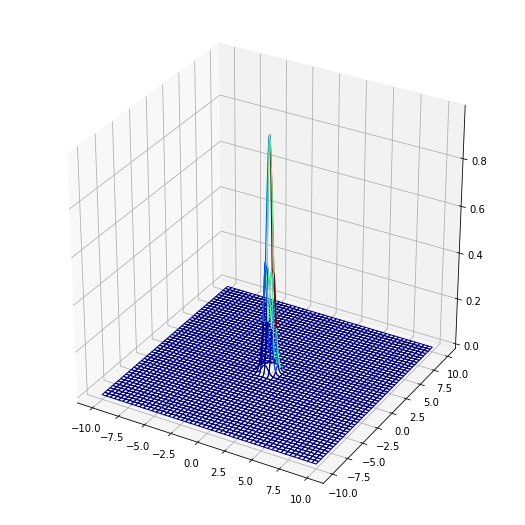

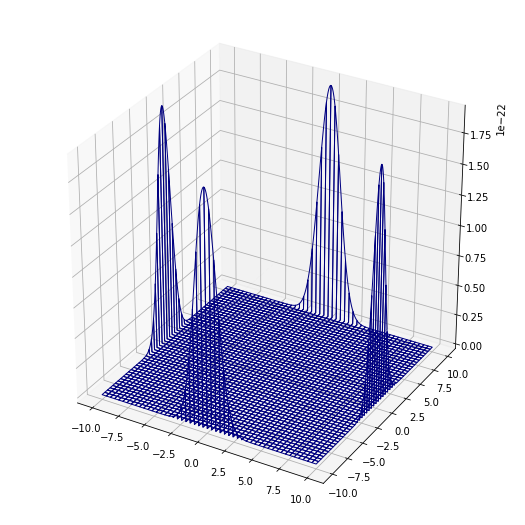

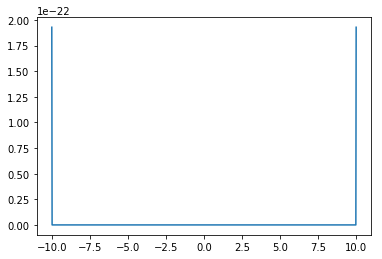

1 9.659648489605324e-20
2 9.659648489605324e-20
3 9.659648489605324e-20


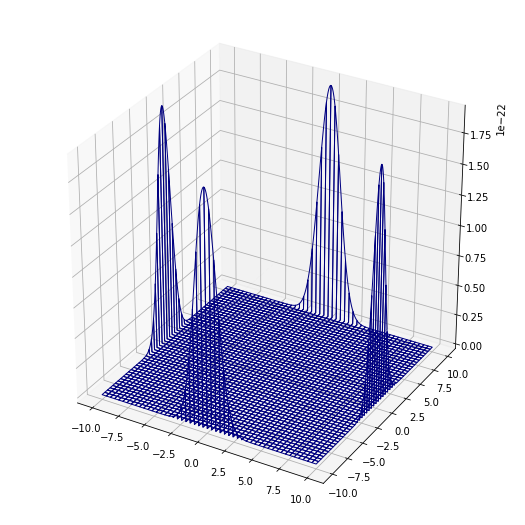

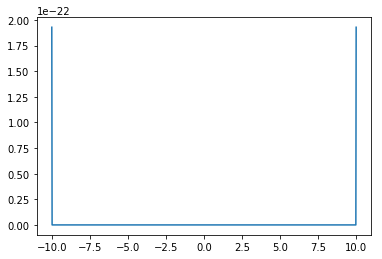

4 9.659648489605324e-20
5 9.659648489605324e-20
6 9.659648489605324e-20


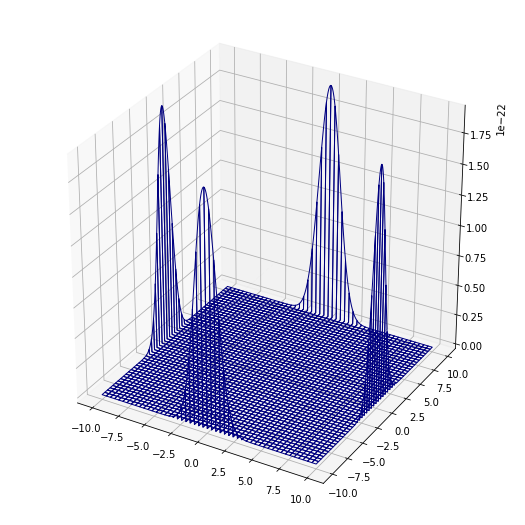

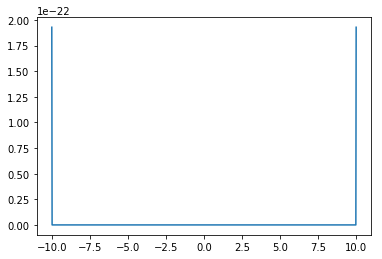

7 9.659648489605324e-20
8 9.659648489605324e-20
9 9.659648489605324e-20


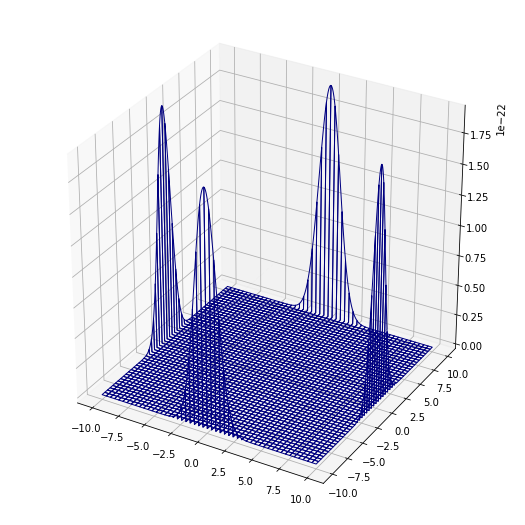

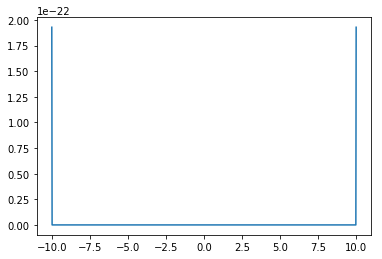

10 9.659648489605324e-20
11 9.659648489605324e-20
12 9.659648489605324e-20


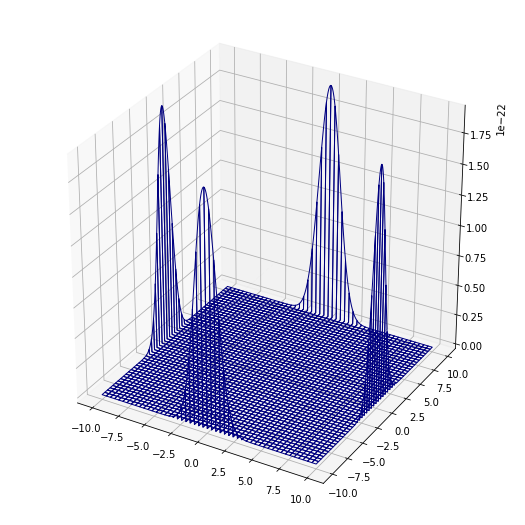

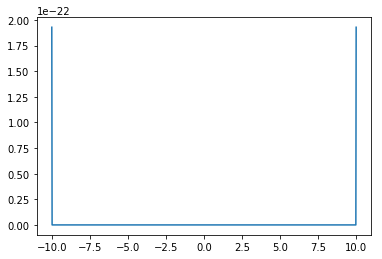

13 9.659648489605324e-20
14 9.659648489605324e-20


In [158]:
Nx = 10**3
Ny = 10**3
x_max = 10
y_max = 10
nsteps = 15
dt = 1e-8
t = np.linspace(0, nsteps*dt, nsteps)

x = np.linspace(-x_max, x_max, Nx)
y = np.linspace(-y_max, y_max, Ny)

xx, yy = np.meshgrid(x, y)

dx = x[1] - x[0]
dy = y[1] - y[0]

initial_values = gaussian_2D(xx, yy, 0, 0)
initial_velocities = np.zeros((Nx, Ny))

fig = plt.figure()
ax = p3.Axes3D(fig)
fig.set_size_inches(7, 7)
surface = ax.plot_surface(xx, yy, initial_values,
                        facecolors=cm.jet(initial_values), shade=False)
surface.set_facecolor((0,0,0,0))


thing = propogate_constant(xx, yy, dx, dy, dt, Nx, Ny, nsteps=nsteps)

for i, t in enumerate(thing):
    print(i, np.sum(t))
    
    if i%3==0:
        fig = plt.figure()
        ax = p3.Axes3D(fig)
        fig.set_size_inches(7, 7)
        surface = ax.plot_surface(xx, yy, t,
                                facecolors=cm.jet(thing[i]), shade=False)
        surface.set_facecolor((0,0,0,0))
        plt.show()
        plt.plot(x, t[len(t)//2])
        plt.show()

In [ ]:
Nx = 10**3
Ny = 10**3
x_max = 10
y_max = 10
nsteps = 5
nframes = nsteps
dt = 1e-3
t = np.linspace(0, nsteps*dt, nsteps)

x = np.linspace(-x_max, x_max, Nx)
y = np.linspace(-y_max, y_max, Ny)

xx, yy = np.meshgrid(x, y)

dx = x[1] - x[0]
dy = y[1] - y[0]

initial_values = gaussian_2D(xx, yy, 0, 0)
initial_velocities = np.zeros((Nx, Ny))

data = propogate(xx, yy, dx, dy, nsteps=nsteps)
#print(data)
fig, ax, surfaces = generate_plot_object(xx, yy, data)
plot = [surfaces]

line_ani = animation.FuncAnimation(fig, update_lines, nframes, fargs=(data, plot, ax),
                                   interval=10, blit=True);

# For a mac (sorta, needs to be modified a little bit):
# Uncomment these lines to save the animation. 
# Please make sure that you download ffmpeg and then set the pointer to the correct location for your system
#plt.rcParams['animation.ffmpeg_path'] = '/home/nathan.meulenbroek/miniconda3/bin'
#line_ani.save('lorentz_system.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

# For windows machine:
saving = False
if saving:
    plt.rcParams['animation.ffmpeg_path'] = 'D:\\Downloads\\ffmpeg-20180227-fa0c9d6-win64-static\\ffmpeg-20180227-fa0c9d6-win64-static\\bin\\ffmpeg.exe'
    FFwriter = animation.FFMpegWriter(fps=60)
    print("Saving")
    line_ani.save('lorentz_system_rotating.mp4', writer=FFwriter, dpi=100)
    print("Saved")